Dataset Shape: (20819, 10)
Total 20819 data points and 10 features.


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


Top 3 Counties:
 County
Santa Clara    810.0
Orange         801.0
Fairfax        624.0
Name: Electric Vehicle (EV) Total, dtype: float64
Bottom 3 Counties:
 County
Bryan      2.0
Dane       2.0
Laramie    2.0
Name: Electric Vehicle (EV) Total, dtype: float64


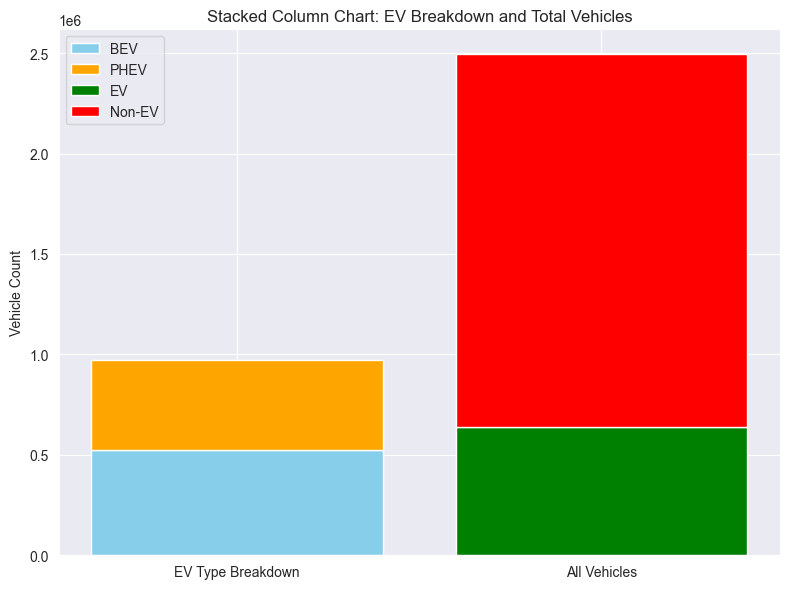

MAE: 0.052549721559268084
RMSE: 0.19319565846643252
R2: 0.9840798924161244


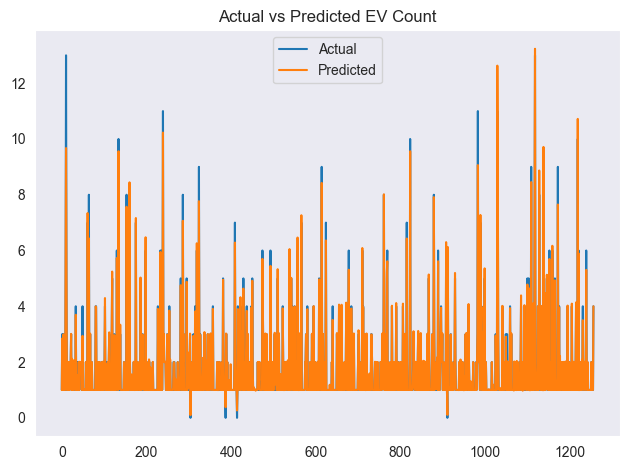

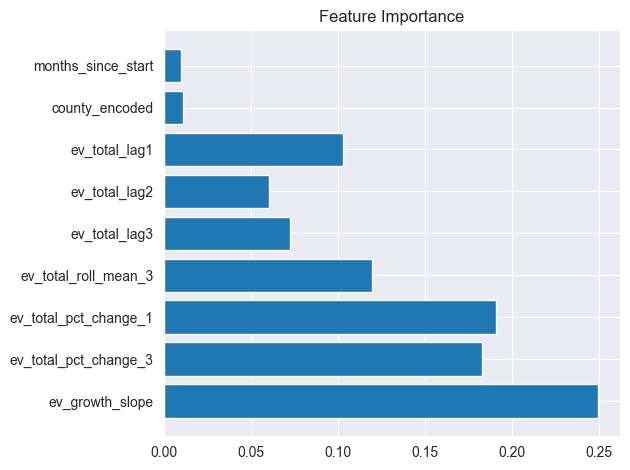

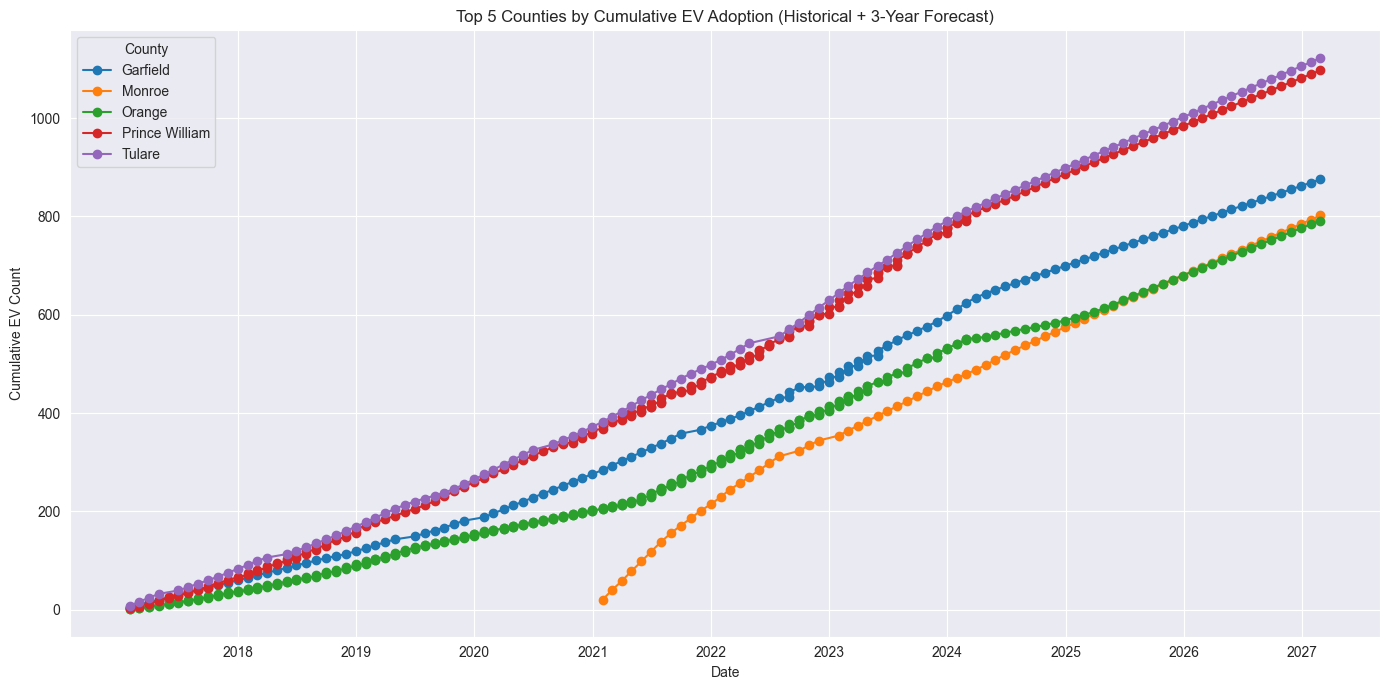

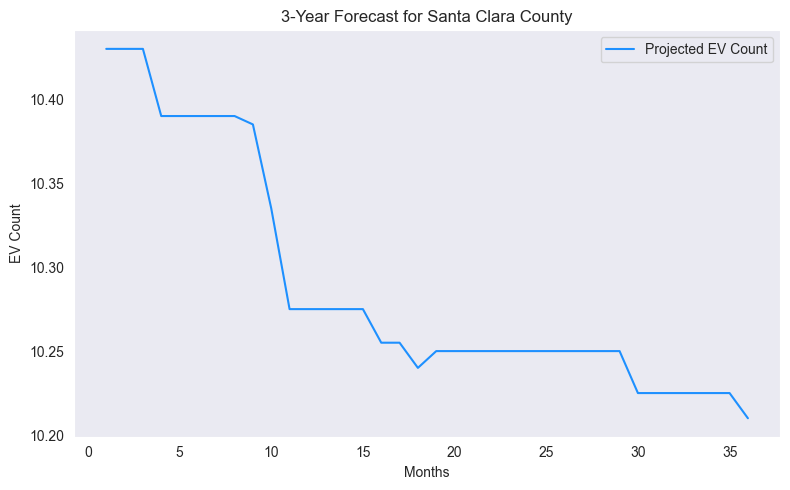

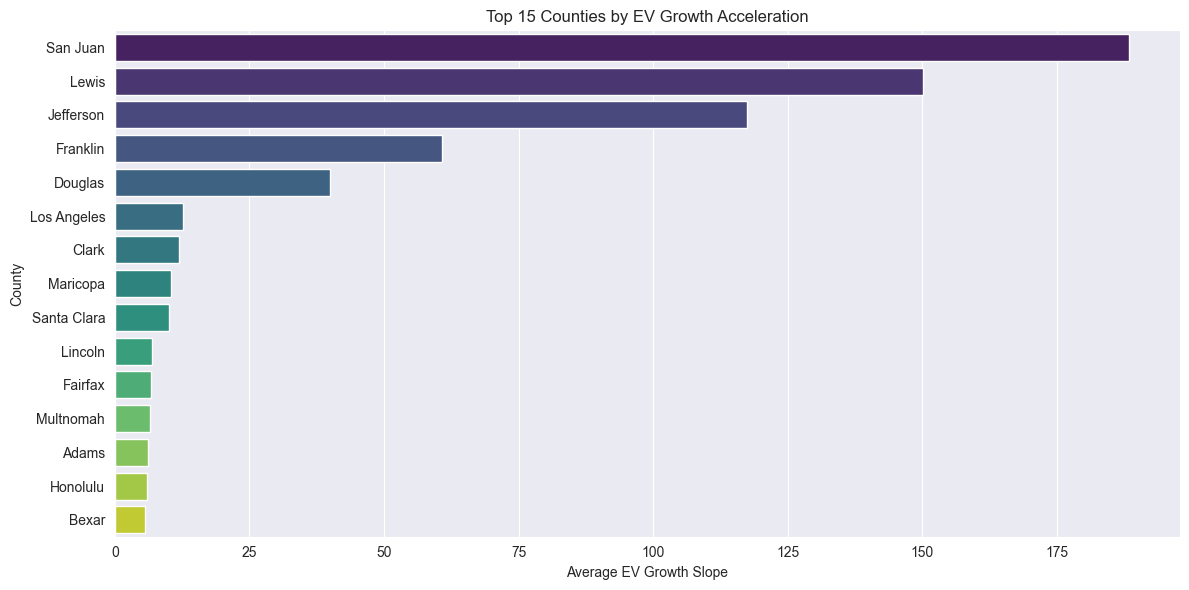

Model saved to 'ev_adoption_forecasting_unique_model.pkl'


In [1]:
# EV Forecasting - Compact & Enhanced Version
import joblib, numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Load and Clean Data
df = pd.read_csv(r"C:\Users\rahul j\Downloads\Electric_Vehicle_Population_By_County.csv")
print("Dataset Shape:", df.shape)
print("Total 20819 data points and 10 features.")
display(df.head())

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notnull() & df['Electric Vehicle (EV) Total'].notnull()]
df.fillna({'County': 'Unknown', 'State': 'Unknown'}, inplace=True)

# 2) Convert to numeric & Outlier Handling
cols_num = ['Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)',
            'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total',
            'Total Vehicles', 'Percent Electric Vehicles']
df[cols_num] = df[cols_num].apply(pd.to_numeric, errors='coerce')

Q1, Q3 = df['Percent Electric Vehicles'].quantile([0.25, 0.75])
IQR = Q3 - Q1
low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df['Percent Electric Vehicles'] = df['Percent Electric Vehicles'].clip(low, high)



# 4) Feature Engineering
df['year'], df['month'] = df['Date'].dt.year, df['Date'].dt.month
df['numeric_date'] = df['year'] * 12 + df['month']
df['months_since_start'] = df.groupby('County').cumcount()
df['county_encoded'] = LabelEncoder().fit_transform(df['County'])

# 3) Save preprocessed data
df.to_csv('preprocessed_ev_data.csv', index=False)

for lag in [1,2,3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

df['ev_total_roll_mean_3'] = (
    df.groupby('County')['Electric Vehicle (EV) Total']
      .transform(lambda x: x.shift(1).rolling(3).mean())
)
df['ev_total_pct_change_1'] = (
    df.groupby('County')['Electric Vehicle (EV) Total']
      .pct_change(fill_method=None)
      .replace([np.inf, -np.inf], 0)
      .fillna(0)
)
df['ev_total_pct_change_3'] = (
    df.groupby('County')['Electric Vehicle (EV) Total']
      .pct_change(periods=3, fill_method=None)
      .replace([np.inf, -np.inf], 0)
      .fillna(0)
)
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()
df['ev_growth_slope'] = (
    df.groupby('County')['cumulative_ev']
      .transform(lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(6), y, 1)[0] if len(y)==6 else np.nan))
)
df.dropna(inplace=True)

# 5) Identify Top/Bottom Counties
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().nlargest(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().nsmallest(3)
print("Top 3 Counties:\n", top_counties)
print("Bottom 3 Counties:\n", bottom_counties)

# 6) EV Breakdown Chart — use separate raw_df so we don't clobber `df` for modeling
raw_df = pd.read_csv(r"C:\Users\rahul j\Downloads\Electric_Vehicle_Population_By_County.csv")
raw_df['Date'] = pd.to_datetime(raw_df['Date'], errors='coerce')
raw_df = raw_df[raw_df['Date'].notnull() & raw_df['Electric Vehicle (EV) Total'].notnull()]
raw_df.fillna({'County':'Unknown','State':'Unknown'}, inplace=True)
raw_df[cols_num[:-1]] = raw_df[cols_num[:-1]].apply(pd.to_numeric, errors='coerce')

bev_total     = raw_df['Battery Electric Vehicles (BEVs)'].sum()
phev_total    = raw_df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total      = raw_df['Electric Vehicle (EV) Total'].sum()
non_ev_total  = raw_df['Non-Electric Vehicle Total'].sum()

fig, ax = plt.subplots(figsize=(8,6))
ax.bar('EV Type Breakdown', bev_total,     label='BEV',   color='skyblue')
ax.bar('EV Type Breakdown', phev_total,    bottom=bev_total, label='PHEV', color='orange')
ax.bar('All Vehicles',        ev_total,    label='EV',    color='green')
ax.bar('All Vehicles',        non_ev_total, bottom=ev_total,   label='Non-EV', color='red')
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend(); plt.tight_layout(); plt.show()

# 7) Prepare Model Data
features = [
    'months_since_start','county_encoded',
    'ev_total_lag1','ev_total_lag2','ev_total_lag3',
    'ev_total_roll_mean_3','ev_total_pct_change_1',
    'ev_total_pct_change_3','ev_growth_slope'
]
X, y = df[features], df['Electric Vehicle (EV) Total']

# 8) Train-Test Split & Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
params = {
    'n_estimators':[100,200],
    'max_depth':[5,10,None],
    'min_samples_split':[2,5],
    'max_features':['sqrt','log2']
}
rf     = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(rf, params, n_iter=20, scoring='r2', cv=3, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)
model = search.best_estimator_

# 9) Evaluate Model
y_pred = model.predict(X_test)
print("MAE:",  mean_absolute_error(y_test,  y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:",   r2_score(y_test,      y_pred))

plt.figure()
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred,      label='Predicted')
plt.title("Actual vs Predicted EV Count")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

# 10) Feature Importance
importances = model.feature_importances_
plt.figure()
plt.barh(features, importances)
plt.title("Feature Importance")
plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()

# 11) Forecast: Top 5 Counties by Cumulative EV Adoption (3-Year)
forecast_horizon = 36  # 3 years = 36 months

all_combined = []
unique_counties = df['County'].dropna().unique()
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(unique_counties)
for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    # Extract initial months_since_start
    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        # Optional: track slope history for acceleration (not used here)
        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        # Store for plotting
        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        # Update EV history
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

# Combine all counties
full_df = pd.concat(all_combined)

# Get final cumulative EV count per county
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Format x-axis to show one tick per year
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()


# 12) Forecast: Total EVs for a Specific County (3-Year)
selected_county = "Santa Clara"
cd = df[df['County']==selected_county].copy()
last = cd.iloc[-1]
months, preds = [], []
for m in range(1,37):
    new = last.copy()
    new['months_since_start'] += m
    for lag in [1,2,3]:
        new[f'ev_total_lag{lag}'] = cd['Electric Vehicle (EV) Total'].iloc[-lag]
    new['ev_total_roll_mean_3']   = cd['Electric Vehicle (EV) Total'].rolling(3).mean().iloc[-1]
    new['ev_total_pct_change_1']  = cd['Electric Vehicle (EV) Total'].pct_change().iloc[-1]
    new['ev_total_pct_change_3']  = cd['Electric Vehicle (EV) Total'].pct_change(3).iloc[-1]
    new['ev_growth_slope']        = cd['cumulative_ev'].rolling(6).apply(lambda y: np.polyfit(range(6), y, 1)[0]).iloc[-1]
    pred = model.predict(pd.DataFrame([new[features]]))[0]
    months.append(m); preds.append(pred)

plt.figure(figsize=(8,5))
plt.plot(months, preds, label="Projected EV Count", color='dodgerblue')
plt.title(f"3-Year Forecast for {selected_county} County")
plt.xlabel("Months"); plt.ylabel("EV Count")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

#Growth Acceleration Map
slope_df = df.groupby('County')['ev_growth_slope'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=slope_df.head(15), x='ev_growth_slope', y='County', palette='viridis',hue='County', legend=False)
plt.xlabel("Average EV Growth Slope")
plt.ylabel("County")
plt.title("Top 15 Counties by EV Growth Acceleration")
plt.tight_layout()
plt.show()


# 13) Save Model
joblib.dump(model, 'ev_adoption_forecasting_unique_model.pkl')
print("Model saved to 'ev_adoption_forecasting_unique_model.pkl'")
